In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/2ccb4e7e4a3f4511a4943215696cfada



In [2]:
# !pip install torchio

In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score
%matplotlib inline

In [4]:
import nilearn
from nilearn import plotting

In [5]:
from data import HCP_MRI_crop

In [6]:
 torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda:3")
else:
  device = torch.device("cpu")

In [8]:
! nvidia-smi

Sat Feb 20 07:13:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:13:00.0 Off |                    0 |
| N/A   23C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   28C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [9]:
data_dir = pathlib.Path('/data/adni')

In [10]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [11]:
PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [12]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Train Dataset size: 889
Test Dataset size: 223
Labels distribution: (array([0, 1]), array([482, 407]))

Train example:
nii
0.5333952903747559
1.7881393432617188e-05


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


0.5637540817260742
0.013710975646972656
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


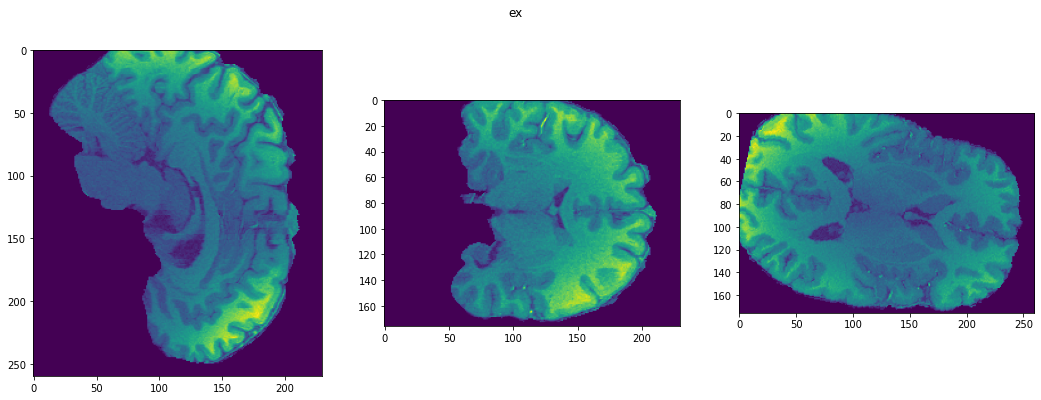

Val example:
nii
0.42063236236572266
1.5974044799804688e-05
0.016172170639038086
0.011873245239257812
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


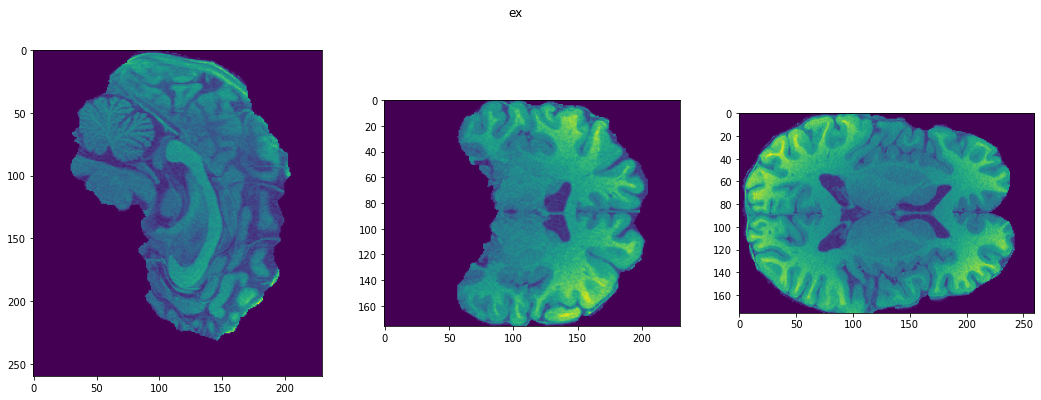

In [13]:
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, random_state=42) 
train_hcp_dataset = HCP_MRI_crop(
    paths= PATH_TO_MRI,
    target_path= X_train,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55,( 15, 15, 0, 19, 34, 51)
    img_shape=(256, 320, 320) #176, 260, 230, (226, 301, 235)
)
val_hcp_dataset = HCP_MRI_crop(
    paths= PATH_TO_MRI,
    target_path= X_test,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55
    img_shape=(256, 320, 320) #176, 260, 230, 226, 301, 235
)

hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
train_transform = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 35),
    RandomAffine(degrees = 0, scale=(0.8, 1.2)) #0.8,1.2
#     ToTensor(),
])

val_transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
train_hcp_dataset.transform = train_transform
val_hcp_dataset.transform = val_transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Train Dataset size: {}".format(len(train_hcp_dataset)))
print("Test Dataset size: {}".format(len(val_hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(train_hcp_dataset.labels, return_counts=True)))

print("Train example:")
img, target = train_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)
print("Val example:")
img, target = val_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [14]:
# def get_crop(subjects):
#     crop = {i: (320, 0) for i in range(3)}
    
#     for subj,_ in tqdm(subjects):
#         subj_bool = subj != 0
#         subj_bool = subj_bool.reshape( (256, 320, 320,1))
# #         print(subj.shape)
# #         print(subj_bool.shape)
#         ax_zero_cut = subj_bool.max(dim=2).values.max(dim=1).values.data.numpy()
# #         print(ax_zero_cut.shape)
#         ax_one_cut = subj_bool.max(dim=2).values.max(dim=0).values.data.numpy()
# #         print(ax_one_cut.shape)
#         ax_two_cut = subj_bool.max(dim=1).values.max(dim=0).values.data.numpy()
# #         print(ax_two_cut.shape)
        
#         ax_zero_min, ax_zero_max = np.where(ax_zero_cut)[0][[0, -1]]
#         ax_one_min, ax_one_max = np.where(ax_one_cut)[0][[0, -1]]
#         ax_two_min, ax_two_max = np.where(ax_two_cut)[0][[0, -1]]
# #         print(ax_zero_min, ax_zero_max)
# #         print(ax_one_min, ax_one_max)
# #         print(ax_two_min, ax_two_max)
#         crop[0] = (min(crop[0][0], ax_zero_min), max(crop[0][1], ax_zero_max + 1))
#         crop[1] = (min(crop[1][0], ax_one_min), max(crop[1][1], ax_one_max + 1))
#         crop[2] = (min(crop[2][0], ax_two_min), max(crop[2][1], ax_two_max + 1))
    
# #     for i in range(3):
#     crop[0] = (crop[0][0], 256 - crop[0][1])
#     crop[1] = (crop[1][0], 320 - crop[1][1])
#     crop[2] = (crop[2][0], 320 - crop[2][1])
    
    
# #     return (crop[1][0], crop[1][1], crop[0][0], crop[0][1], crop[2][0], crop[2][1])
#     return (crop[0][0], crop[0][1], crop[1][0], crop[1][1], crop[2][0], crop[2][1])

# crop = get_crop(hcp_dataset)
# # crop = (49, 22, 49, 47, 19, 28)(15, 15, 0, 19, 34, 51)
# print(crop)

In [16]:
train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

# Model structure

In [17]:
# timing
from tqdm import tqdm

def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [18]:
torch.cuda.empty_cache()

In [19]:
CHECKPOINTS_DIR =  '/home/checkpoints_rot_spcrop/'

In [20]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [21]:
if torch.cuda.device_count() > 1:
      d_ids= [3,4]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [3, 4] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [22]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [23]:
model_name = '_checkpoints_crop_scale'
experiment.set_name("3DCNN_checkpoints_crop_scal")

In [24]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 40

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

100%|██████████| 112/112 [01:30<00:00,  1.23it/s]


Epoch 00/40 || Loss:  Train 34.0552 | Validation 36.0281


100%|██████████| 112/112 [01:30<00:00,  1.23it/s]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/40 || Loss:  Train 1.4295 | Validation 1.0452 Acc: Train 70.3037 | Validation 73.9910


100%|██████████| 112/112 [01:30<00:00,  1.24it/s]


Epoch 02/40 || Loss:  Train 0.5029 | Validation 0.3173 Acc: Train 87.5141 | Validation 90.1345


100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Epoch 03/40 || Loss:  Train 0.3429 | Validation 0.2952 Acc: Train 89.3138 | Validation 91.9283


100%|██████████| 112/112 [01:43<00:00,  1.08it/s]


Epoch 04/40 || Loss:  Train 0.3314 | Validation 0.5618 Acc: Train 88.0765 | Validation 84.3049


100%|██████████| 112/112 [01:58<00:00,  1.06s/it]


Epoch 05/40 || Loss:  Train 0.3055 | Validation 0.3025 Acc: Train 89.5388 | Validation 90.1345


100%|██████████| 112/112 [01:54<00:00,  1.02s/it]


Epoch 06/40 || Loss:  Train 0.2430 | Validation 0.2435 Acc: Train 91.5636 | Validation 93.2735


100%|██████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch 07/40 || Loss:  Train 0.2277 | Validation 0.2440 Acc: Train 92.6884 | Validation 91.9283


100%|██████████| 112/112 [01:52<00:00,  1.00s/it]


Epoch 08/40 || Loss:  Train 0.2159 | Validation 0.3948 Acc: Train 92.0135 | Validation 86.9955


100%|██████████| 112/112 [01:55<00:00,  1.03s/it]


Epoch 09/40 || Loss:  Train 0.2396 | Validation 0.3424 Acc: Train 90.8886 | Validation 89.6861


100%|██████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch 10/40 || Loss:  Train 0.2221 | Validation 0.2384 Acc: Train 91.9010 | Validation 91.4798


100%|██████████| 112/112 [01:53<00:00,  1.01s/it]


Epoch 11/40 || Loss:  Train 0.1750 | Validation 0.2176 Acc: Train 93.4758 | Validation 92.3767


100%|██████████| 112/112 [01:57<00:00,  1.05s/it]


Epoch 12/40 || Loss:  Train 0.2028 | Validation 0.3994 Acc: Train 92.1260 | Validation 87.8924


100%|██████████| 112/112 [01:54<00:00,  1.02s/it]


Epoch 13/40 || Loss:  Train 0.2009 | Validation 0.2297 Acc: Train 93.0259 | Validation 94.1704


100%|██████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch 14/40 || Loss:  Train 0.1901 | Validation 0.2198 Acc: Train 93.1384 | Validation 92.3767


100%|██████████| 112/112 [01:53<00:00,  1.01s/it]


Epoch 15/40 || Loss:  Train 0.2063 | Validation 0.2362 Acc: Train 93.0259 | Validation 93.2735


100%|██████████| 112/112 [01:54<00:00,  1.03s/it]


Epoch 16/40 || Loss:  Train 0.1949 | Validation 0.2670 Acc: Train 92.1260 | Validation 91.0314


100%|██████████| 112/112 [01:57<00:00,  1.05s/it]


Epoch 17/40 || Loss:  Train 0.1838 | Validation 0.2585 Acc: Train 92.6884 | Validation 91.0314


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 18/40 || Loss:  Train 0.1588 | Validation 0.2235 Acc: Train 94.0382 | Validation 91.9283


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 19/40 || Loss:  Train 0.1842 | Validation 0.2073 Acc: Train 92.9134 | Validation 91.9283


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 20/40 || Loss:  Train 0.1833 | Validation 0.2030 Acc: Train 92.2385 | Validation 94.1704


100%|██████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch 21/40 || Loss:  Train 0.1796 | Validation 0.2933 Acc: Train 92.4634 | Validation 91.4798


100%|██████████| 112/112 [01:55<00:00,  1.03s/it]


Epoch 22/40 || Loss:  Train 0.1973 | Validation 0.2671 Acc: Train 92.6884 | Validation 91.0314


100%|██████████| 112/112 [01:55<00:00,  1.03s/it]


Epoch 23/40 || Loss:  Train 0.1570 | Validation 0.1954 Acc: Train 93.8133 | Validation 93.7220


100%|██████████| 112/112 [01:55<00:00,  1.03s/it]


Epoch 24/40 || Loss:  Train 0.2034 | Validation 0.1968 Acc: Train 91.5636 | Validation 93.2735


100%|██████████| 112/112 [01:52<00:00,  1.01s/it]


Epoch 25/40 || Loss:  Train 0.1500 | Validation 0.1945 Acc: Train 94.6007 | Validation 93.7220


100%|██████████| 112/112 [01:52<00:00,  1.00s/it]


Epoch 26/40 || Loss:  Train 0.1656 | Validation 0.3485 Acc: Train 93.7008 | Validation 87.8924


100%|██████████| 112/112 [01:57<00:00,  1.05s/it]


Epoch 27/40 || Loss:  Train 0.1648 | Validation 0.2549 Acc: Train 94.4882 | Validation 90.5830


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 28/40 || Loss:  Train 0.1952 | Validation 0.1933 Acc: Train 92.4634 | Validation 95.0673


100%|██████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch 29/40 || Loss:  Train 0.1717 | Validation 0.1902 Acc: Train 92.3510 | Validation 94.6188


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 30/40 || Loss:  Train 0.1423 | Validation 0.2814 Acc: Train 95.2756 | Validation 91.9283


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 31/40 || Loss:  Train 0.1564 | Validation 0.3214 Acc: Train 94.2632 | Validation 88.7892


100%|██████████| 112/112 [01:46<00:00,  1.05it/s]


Epoch 32/40 || Loss:  Train 0.1465 | Validation 0.2481 Acc: Train 93.8133 | Validation 91.4798


100%|██████████| 112/112 [01:48<00:00,  1.03it/s]


Epoch 33/40 || Loss:  Train 0.1213 | Validation 0.2087 Acc: Train 95.0506 | Validation 91.9283


100%|██████████| 112/112 [01:46<00:00,  1.05it/s]


Epoch 34/40 || Loss:  Train 0.1442 | Validation 0.1965 Acc: Train 94.1507 | Validation 92.8251


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 35/40 || Loss:  Train 0.1409 | Validation 0.1766 Acc: Train 94.4882 | Validation 94.6188


100%|██████████| 112/112 [01:55<00:00,  1.03s/it]


Epoch 36/40 || Loss:  Train 0.1495 | Validation 0.1831 Acc: Train 94.6007 | Validation 94.6188


100%|██████████| 112/112 [01:56<00:00,  1.04s/it]


Epoch 37/40 || Loss:  Train 0.1532 | Validation 0.2109 Acc: Train 93.9258 | Validation 92.3767


100%|██████████| 112/112 [01:52<00:00,  1.00s/it]


Epoch 38/40 || Loss:  Train 0.1468 | Validation 0.2258 Acc: Train 94.0382 | Validation 92.3767


100%|██████████| 112/112 [01:53<00:00,  1.02s/it]


Epoch 39/40 || Loss:  Train 0.1433 | Validation 0.1877 Acc: Train 94.3757 | Validation 94.6188


100%|██████████| 112/112 [01:49<00:00,  1.03it/s]

Epoch 40/40 || Loss:  Train 0.1142 | Validation 0.1925 Acc: Train 95.6130 | Validation 95.0673


In [25]:
model.load_state_dict(torch.load('/home/checkpoints_rot_spcrop/best_acc_model__checkpoints_crop_scale'))
model.eval()

DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [29]:
get_metric(model, val_loader)

100%|██████████| 112/112 [01:50<00:00,  1.01it/s]


(95.06726837158203, 0.9515447154471545, 0.9320388349514563, 0.96)

In [30]:
get_metric(model, train_loader)

  0%|          | 0/223 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
100%|██████████| 223/223 [11:50<00:00,  3.19s/it]


(94.60067749023438,
 0.5198318839397678,
 0.4792176039119804,
 0.48157248157248156)